>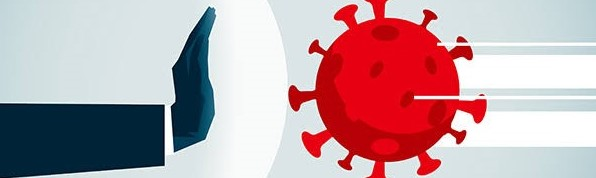

#              &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp;          <u>Diagnosis of COVID-19 and its Clinical Spectrum</u>

> ### <i>Brief Introduction</i> 

Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus. Most people infected with
the COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment. 
Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness.(Reference:https://www.who.int/)


### Objectives
1. Analyze and Display various relationships among parameters/features related to Hemogram
2. Predicting Disease Severity

***

### Index

* [Brief Introduction](#Brief-Introduction)
* [Objectives](#Objectives)
* [Libraries to be used](#Libraries-to-be-used)
* [Dataset Description and Usage](#Dataset-Description-and-Usage)
* [What the dataset speaks about?](#speak)
* [Analysis of Missing Values](#Analysis-of-Missing-Values)
* [Data Cleansing](#Data-Cleansing)
* [Dataset Balance](#balance)
* [Theoretically relevant features and Visualization](#theory)
* [Probability: Intensive/Semi-intensive/Regular care](#probability)
* [Risk analysis](#risk)
* [Data-driven Hemogram analysis using t-SNE](#tsne)
* [Conclusions](#Conclusions)

### Libraries to be used

* Pandas - for dataset handling
* Numpy - Support for Pandas and calculations 
* Matplotlib - for visualization (Plotting graphs)
* Plotly - for interative plots
* Sklearn - for Data Processing
* Os - for OS related operations

In [ ]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import warnings
import os
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0}) #just to suppress warning for max plots of 20
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
# Display output not only of last command but all commands in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# Set pandas options to display results
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

### Dataset Description and Usage

This dataset contains anonymized data from patients seen at the Hospital Israelita Albert Einstein, at São Paulo, Brazil, and who had samples collected to perform the SARS-CoV-2 RT-PCR and additional laboratory tests during a visit to the hospital.All data were anonymized following the best international practices and recommendations. All clinical data were standardized to have a mean of zero and a unit standard deviation.

This dataset is categorized based on:
1. Presence/absence of the Sars-COV-2 pathogen
2. intensity of care dedicated to the patient (regular ward, semi-intensive care, and intensive care)
3. Data related to other pathogens (collected as per Standard Procedure for individuals treated under Private Health insurance)
4. Data Related to common non-standard features that can be analyzed in any blood test

#### Usage
Since the availability of data directly reflects socio-economic aspects of the patients, such aspects are not reported in the dataset. Therefore, in order to ensure that patients are treated well,we will-
1. Subset the dataset based on infection diseases
2. Study based only upon complete data with regards to features (i.e., *we do not perform data imputation*)

In [ ]:
# Load dataset
df = pd.read_csv("../input/uncover/einstein/diagnosis-of-covid-19-and-its-clinical-spectrum.csv")
#Let's try to analyze the dataset based on what is availiable with us
df.info()
df.head()
df.describe()

<a id="speak"></a>
### What the dataset speaks about?

There are Total 111 Columns spreaded over 5644 number of entries. Object 41, means that there are *41 Categorical* columns and cannot be described exclusively. *Standard Deviation* for most of the numerical columns is approx. *1* except for patient_age_quantile. Variation in statistical values indicates that Dataset is intensively irregular.

This dataset consists of information about
1. Presence/absence of the Sars-COV-2 pathogen
2. intensity of care dedicated to the patient (regular ward, semi-intensive care and intensive care)
3. Data related to blood tests/hemogram
4. Data related to other pathogens
We will use above results to subset the dataset for further study.

### Analysis of Missing Values 

We will analyze the missing values(i.e. NaN) present in the dataset so as the results can be used for subsetting the dataset.

In [ ]:
# Segragate the sars_cov_2_exam_result into positive and negative
#df_positive = df[df['sars_cov_2_exam_result']=='positive']
#df_negative = df[df['sars_cov_2_exam_result']=='negative']
 
# Set Index as patient_id 
#df = df.set_index('patient_id')

missing_values = df.isna().sum()/len(df)

print("Total number of tuples:", len(df))
print("Percentage of  missing values:", round(missing_values.mean()*100,1),"%")

data_not_avlbl = []
for i in np.arange(0, len(df.columns), 10):
    data_not_avlbl.append(str(i)+"%");
plt.figure(figsize=[10,30]);

plt.yticks(np.arange(len(df.columns)), missing_values.index.values);
plt.xticks(np.arange(0, 1.1, .1), data_not_avlbl);

plt.ylim(0,len(df.columns));

plt.barh(np.arange(len(df.columns)), missing_values,color="darkcyan");

We can see from above chart that features of the hemogram are about 89% missing values. Since the objective of our notebook is to analyze hemogram features, we now filter the features of only values that are available. We use the column Hematocrit, a blood test feature to filter out the data.

In [ ]:
df_filtered = df[~np.isnan(df['hematocrit'])]
missing_values_filtered = df_filtered.isna().sum()/len(df_filtered)

print("Filtered Number of Tuples:", len(df_filtered))
print("Average percentage missing values:", round(missing_values_filtered.mean()*100,1),"%")


data_not_avlbl_filtered = []
for i in np.arange(0, 110, 10):
    data_not_avlbl_filtered.append(str(i)+"%");
plt.figure(figsize=[10,30]);

plt.yticks(np.arange(len(df_filtered.columns)), missing_values_filtered.index.values);
plt.xticks(np.arange(0, 1.1, .1), data_not_avlbl_filtered);

plt.ylim(0,len(df_filtered.columns));

plt.barh(np.arange(len(df_filtered.columns)), missing_values_filtered,color="darkcyan");

<hr>As we see can that, after selecting the tuples that have blood test features, the number of rows dropped by about 90% and the incidences of missing values for some of the features is very high, some of them with more than 80%. For the analysis to be less influenced by imputing a high number of missing values, we now apply a filter to features that have less than 40% missing values<hr>

In [ ]:
df_filtered = df_filtered[missing_values_filtered[missing_values_filtered<=.4].index.values]

missing_values_filtered = df_filtered.isna().sum()/len(df_filtered)

print("Total Number of Tuples:", len(df_filtered))
print("Average percentage missing values:", round(missing_values_filtered.mean()*100,1),"%")

data_not_avlbl = []
for i in np.arange(0, 110, 10):
    data_not_avlbl.append(str(i)+"%");
plt.figure(figsize=[10,20]);

plt.yticks(np.arange(len(df_filtered.columns)), missing_values_filtered.index.values);
plt.xticks(np.arange(0, 1.1, .1), data_not_avlbl);

plt.ylim(0,len(df_filtered.columns));

plt.barh(np.arange(len(df_filtered.columns)), missing_values_filtered,color="darkcyan");



Finally, we can figure out the features that could be decision factors with maximmum accuracy<hr>

### Data Cleansing

For imputation of data in missing values, different strategies for Numerical & Categorical data can be adopted as below:
* Numerical: imputation of median
* Categorical: imputation of mode & transform into dummy columns

In [ ]:
df_pos_neg_treated = df_filtered
#filter out the categorical features from filtered dataset
cat_features = df_filtered.dtypes[df_filtered.dtypes == 'object'].index.values 
#fill NaN values for filtered categorical values
for feature in cat_features:
    df_pos_neg_treated[feature] = df_pos_neg_treated[feature].fillna(df_pos_neg_treated[feature].mode().values[0]) 
    
df_pos_neg_treated = df_pos_neg_treated.fillna(df_pos_neg_treated.median())

df_pos_neg_treated_dummies = pd.get_dummies(df_pos_neg_treated, drop_first=True, dtype='bool')

columns = list(df_pos_neg_treated_dummies.drop(labels=['sars_cov_2_exam_result_positive'],axis=1).columns.values)
columns.append('sars_cov_2_exam_result_positive')

df_pos_neg_treated_dummies = df_pos_neg_treated_dummies[columns]

<a id="balance"></a>
### Dataset Balance
Let's find the balance between Positive and Negative Treated patients

In [ ]:
ax = df_pos_neg_treated['sars_cov_2_exam_result'].value_counts().plot(kind='bar',figsize=(8,4),color="darkcyan");
ax.set_xticklabels(['negative', 'positive'], rotation=0, fontsize=15);


This means that most of the values are negative only and <b>Dataset can't be termed as a balanced database</b>.<br>

In [ ]:
#df.columns.values
df['patient_addmited_to_regular_ward_1_yes_0_no'] = df['patient_addmited_to_regular_ward_1_yes_0_no'].map({
                                    't' : 1, 'f' : 0   })
df['patient_addmited_to_semi_intensive_unit_1_yes_0_no'] = df['patient_addmited_to_semi_intensive_unit_1_yes_0_no'].map({
                                    't' : 1, 'f' : 0   })
df['patient_addmited_to_intensive_care_unit_1_yes_0_no'] = df['patient_addmited_to_intensive_care_unit_1_yes_0_no'].map({
                                    't' : 1, 'f' : 0   })

In [ ]:
unit_ward_types =  ['patient_addmited_to_regular_ward_1_yes_0_no',\
                'patient_addmited_to_semi_intensive_unit_1_yes_0_no',\
                 'patient_addmited_to_intensive_care_unit_1_yes_0_no']
def_hemogram_cols = list(df.columns[6:20])
parameters = ['lymphocytes', 'neutrophils', 'sodium', 'potassium', 'creatinine','proteina_c_reativa_mg_dl']

list_unit_ward_types = ['No-care', 'Regular', 'Semi-Intensive', 'Intensive']

cors = 'sars_cov_2_exam_result'


<a id="theory"></a>
### Theoretically relevant features and Visualization

Some of the theoretically relevant features in Hemogram are:
Lymphocites, Neutrophils,Sodium, Potassium, Creatinine, C Reactive Protein(CRP)


* <u> Sodium, Potassium</u>: They are related to active cell membrane transportations, which could be altered in the presence of specific types of infections which includs virus/bacterial infections as well.

* <u> Lymphocites, Neutrophiles</u>: They tend to grow as a body response to virus/bacterial infections. Growth of these cells is not linear and depends on the infection time, they start with decrease, then they rise. The timeline is not available in our dataset.

* <u>Creatinine,  C Reactive Protein(CRP)</u>: Creatinine tends to grow with age and can be used as an indicator for liver malfunction, which is a pre-existing condition that could lead to more severe cases of COVID-19 whereas alterations in <u> CRP</u> happen in many cases of infections and other body disturbances CRP between 100 and 500 mg/L is considered highly predictive of inflammation due to bacterial infection


In [ ]:
data_join = df[unit_ward_types + parameters].dropna().to_numpy(copy=True)

In [ ]:
#df = pd.read_csv("diagnosis-of-covid-19-and-its-clinical-spectrum.csv")
unit_ward_types_y_ = data_join[:,0:3] # ward_types columns
y = unit_ward_types_y_[:,0] #1st ward_type series 
y [unit_ward_types_y_[:,1]==1]=2 #2nd ward_type series semi-icu Assign value 2
y [unit_ward_types_y_[:,2]==1]=3 #3rd ward_type series icu Assign value 3
X = data_join[:,3:]  #Parameters columns

# Sodium vs. Potassium
plt.figure();
for i in range(len(list_unit_ward_types)):
    idx = np.where(y == i)[0]
    plt.scatter(X[idx,2], X[idx,3], alpha=0.6, label=list_unit_ward_types[i]);
plt.legend();
plt.xlabel('Sodium');
plt.ylabel('Potassium');
plt.show();

# Lymphocytes vs. Neutrophils
plt.figure();
for i in range(len(list_unit_ward_types)):
    idx = np.where(y == i)[0]
    plt.scatter(X[idx,0], X[idx,1], alpha=0.6, label=list_unit_ward_types[i]);
plt.legend();
plt.xlabel('Lymphocytes');
plt.ylabel('Neutrophils');
plt.show();

# Creatinine and CRP
plt.figure();
for i in range(len(list_unit_ward_types)):
    idx = np.where(y == i)[0]
    plt.scatter(X[idx,4], X[idx,5], alpha=0.6, label=list_unit_ward_types[i]);
plt.legend();
plt.xlabel('Creatinine');
plt.ylabel('C Reactive Protein(CRP)');
plt.show();

plt.figure();
for i in range(len(list_unit_ward_types)):
    idx = np.where(y == i)[0]
    plt.scatter(X[idx,4], X[idx,5], alpha=0.6, label=list_unit_ward_types[i]);
plt.legend();
plt.xlabel('Creatinine');
plt.ylabel('C Reactive Protein(CRP)');
plt.show();

Above visualizations are overlapped clouds on for regular, semi-intensive, and intensive-care patients.

Let's perform the visualizations based only upon Patients who <b>Tested Positive for Sars-Cov-2</b>

In [ ]:
# Feature visualization only for SARS-Cov-2 positives
#df = pd.read_csv("diagnosis-of-covid-19-and-its-clinical-spectrum.csv")
positive_df_ = df[ df['sars_cov_2_exam_result'] == 'positive']
data_join = positive_df_[unit_ward_types + parameters].dropna().to_numpy(copy=True)

unit_ward_types_y_ = data_join[:,0:3];
y = unit_ward_types_y_[:,0];
y [unit_ward_types_y_[:,1]==1]=2;
y [unit_ward_types_y_[:,2]==1]=3;
X = data_join[:,3:];

# Sodium vs. Potassium
plt.figure();
for i in range(len(list_unit_ward_types)):
    idx = np.where(y == i)[0]
    plt.scatter(X[idx,2], X[idx,3], alpha=0.6, label=list_unit_ward_types[i]);
plt.legend();
plt.xlabel('Sodium');
plt.ylabel('Potassium');
plt.show();

# Lymphocytes vs. Neutrophils
plt.figure();
for i in range(len(list_unit_ward_types)):
    idx = np.where(y == i)[0]
    plt.scatter(X[idx,0], X[idx,1], alpha=0.6, label=list_unit_ward_types[i]);
plt.legend();
plt.xlabel('Lymphocytes');
plt.ylabel('Neutrophils');
plt.show();

# Creatinine and CRP
plt.figure();
for i in range(len(list_unit_ward_types)):
    idx = np.where(y == i)[0]
    plt.scatter(X[idx,4], X[idx,5], alpha=0.6, label=list_unit_ward_types[i]);
plt.legend();
plt.xlabel('Creatinine');
plt.ylabel('C Reactive Protein (CRP)');
plt.show();

Based on above two sets of Visualizations, it is quite clear that when we visualize data without considering the pathogen tests, we see fuzzy point cloud without any grouping dots. Notably, when we only consider patients that tested positive for the pathogens, we observe the following:

1. Higher CRP & Lower Lymphocytes level suggest a higher probability for the patients to be kept in Intensive Care Units
2. Higher Creatinine coupled with high CRP indicates a high chance of requiring care

As mentioned in Theoretically relevant features part, nature of lymphocytes can be due to the disease evolution timeline.
<a id="probability"></a>
### Probability: Intensive/Semi-intensive/Regular care

Let's estimate the probability of requiring intensive or Semi-intensive care based on the CRP and the Lymphocytes readings. 

In [ ]:
plt.figure();
for i in range(len(list_unit_ward_types)):
    idx = np.where(y == i)[0];
    plt.scatter(X[idx,0], X[idx,5], alpha=0.6, label=list_unit_ward_types[i]);
plt.legend();
plt.xlabel('Lymphocytes');
plt.ylabel('C Reactive Protein(CRP)');
plt.show();

It can be concluded from the above graph that, <u>when CRP is lower, No-Care is required</u>. Whereas, as the <u>CRP goes higher and Lymphocytes level is low</u>, the chances of requiring <i>Intensive care gets increased</i>.

With this, if we choose to estimate a parametric distribution for this probability, then we should base our distribution function on Epidemiology Theory - using which we assume that a Gaussian distribution is enough, considering that there are so few data points here.(<i>Reference:https://en.wikipedia.org/wiki/Epidemiology</i>).

In order to focus on special care area, let's choose a chunk from the entire region and then perform the analysis. 
For this, let's select the parametric ranges as:
1. Lymphocytes = 1.3, above which only one subject required hospital care,
2. CRP = -0.4, above which (provided that Lymphocites < 1.3), Ignoring, only one patient did not undergo any care.

Let's perform the visualization for Risky Area:

In [ ]:
plt.figure();
for i in range(len(list_unit_ward_types)):
    idx = np.where(y == i)[0];
    plt.scatter(X[idx,0], X[idx,5], alpha=0.6, label=list_unit_ward_types[i]);
    
plt.plot([-2, 1.3, 1.3, -2, -2], [-0.4, -0.4, 3.5, 3.5, -0.4], 'r');# Coordinates forming a Rectangle
plt.plot([1.3, 1.3], [-0.4, 1.5], 'r', label='Risky Area');

plt.legend();
plt.xlabel('Lymphocytes');
plt.ylabel('C Reactive Protein(CRP)');
plt.show();

Risk will be more, when CRP is higher and Lymphocites is lower.
<a id="risk"></a>
### Risk analysis
Two types of analysis can be made, Inside the Rectangle and Outside the Rectangle.

| Risk Type | Inside the Rectangle | Outside the Rectangle |
| --- | --- | --- |
|Risk of Requiring Intensive Care|20|0|
|Risk of Requiring Semi-Intensive Care|20|0|
|Risk of Requiring Regular Care|47|0|
|Risk of Requiring No-Care|87|60|


<a id="tsne"></a>
### Data-driven Hemogram analysis using t-SNE

Let's make use of some machine learning tools and linear algebra tools to detect intensity of symptoms from the Full hemogram.
<i>(Reference: https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1)</i>.

t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data. In simpler terms, t-SNE gives you a feel or intuition of how the data is arranged in a high-dimensional space. The distortion included by t-SNE is such that points that short distances in the original spaces are preserved, but large distances are distorted.

In [ ]:
# Feature visualization- Hemogram data
#df = pd.read_csv("diagnosis-of-covid-19-and-its-clinical-spectrum.csv")

data_join = df[unit_ward_types + parameters].dropna().to_numpy(copy=True);

unit_ward_types_y_ = data_join[:,0:3];
y = unit_ward_types_y_[:,0];
y [unit_ward_types_y_[:,1]==1]=2;
y [unit_ward_types_y_[:,2]==1]=3;
X = data_join[:,3:];

scaler = StandardScaler();
scaler.fit(X);
X_ = scaler.transform(X);

# t-SNE visualization
tsne = TSNE(n_components=2);
Xtsne = tsne.fit_transform(X_);

plt.figure();
for i in range(len(list_unit_ward_types)):
    idx = np.where(y == i)[0];
    plt.scatter(Xtsne[idx,0], Xtsne[idx,1], alpha=0.6, label=list_unit_ward_types[i]);

plt.title('t-SNE visualization');
plt.legend();
plt.show();

There aren't any groupings in these plots, so let's perform analysis on patients who were tested positive for the Sars-Cov-2-exam.

In [ ]:
# Feature visualization - Hemogram parameters for SARS-Cov-2-positives
#df = pd.read_csv("diagnosis-of-covid-19-and-its-clinical-spectrum.csv")
positive_df_ = df[ df['sars_cov_2_exam_result'] == 'positive'];
data_join = positive_df_[unit_ward_types + parameters].dropna().to_numpy(copy=True);

unit_ward_types_y_ = data_join[:,0:3];
y = unit_ward_types_y_[:,0];
y [unit_ward_types_y_[:,1]==1]=2;
y [unit_ward_types_y_[:,2]==1]=3;
X = data_join[:,3:];

scaler = StandardScaler();
scaler.fit(X);
X_ = scaler.transform(X);

# t-SNE visualization
tsne = TSNE(n_components=2, perplexity=30);#perplexity is related to the number of nearest neighbors
Xtsne = tsne.fit_transform(X_);

plt.figure();
for i in range(len(list_unit_ward_types)):
    idx = np.where(y == i)[0];
    plt.scatter(Xtsne[idx,0], Xtsne[idx,1], alpha=0.6, label=list_unit_ward_types[i]);

plt.title('t-SNE visualization');
plt.legend();
plt.show();

### Conclusions

    - The dataset has majorly missing values; the dataset can be termed as Highly irregular.
    - More data readings would yield more accuracy in results.
    - The dataset has no mention about death or recovery of patient after admitted into any of the ward type.
    - Higher CRP & Lower Lymphocytes level suggest a higher probability for the patients to be kept in Intensive Care Units
    - Higher Creatinine coupled with high CRP indicates a high chance of requiring care
    - There is a strong relationship between C Reactive Protein (CRP) and Lymphocyte 
    - Low CRP and High Lymphocytes show lower chance of requiring Intensive Care and this forms the disease severity.